In [1]:
#Because jedi completer is terrible!!!
%config Completer.use_jedi = False

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn import tree


from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics

import statsmodels.api as sm

In [3]:
dataFrame = pd.read_csv('./data/forestfires.csv')

### Check for NULLs

In [4]:
dataFrame.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

### Summary of the data

In [5]:
dataFrame.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### Rain Column

##### Rain column is COMPLETELY useless

In [6]:
print(len(dataFrame[dataFrame['rain'] > 0]))

dataFrame[dataFrame['rain'] > 0]

8


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
243,7,4,aug,sun,91.8,175.1,700.7,13.8,21.9,73,7.6,1.0,0.00
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17


#### Drop 'rain' column

In [7]:
dataFrame.drop(labels=['rain'], axis = 1, inplace=True)

### Adding a burn flag column

##### Add a flag column

##### 0 Burn = 0
##### Non 0 burn = 1

In [8]:
areaValues = dataFrame[['area']].values

In [9]:
areaFlag = []

for each in areaValues:
    
    if each[0] == 0:
        
        areaFlag.append(0)
        
    else:
        
        areaFlag.append(1)

In [10]:
dataFrame['burn'] = areaFlag

### Adding a burn flag with 3 classes

##### Add another flag column

##### 0 burn = 0
##### burn less than 10 = 1
##### burn more than 10 = 2

In [11]:
burnLabel = []

for each in areaValues:
    
    if each[0] == 0:
        
        burnLabel.append(0)
        
    elif each[0] > 0 and each[0] < 10:
        
        burnLabel.append(1)
        
    else:
        
        burnLabel.append(2)

In [12]:
dataFrame['burnscale'] = burnLabel

### Burn Label distribution

In [13]:
len(dataFrame[dataFrame['burnscale'] == 0])

247

In [14]:
len(dataFrame[dataFrame['burnscale'] == 1])

175

In [15]:
len(dataFrame[dataFrame['burnscale'] == 2])

95

### Exploring the distribution of area values

In [16]:
len(dataFrame)

517

#### There are a total of 517 records

#### Let us check the number of records with 0 and non 0 burnt areas

In [17]:
print('The number of records with zero burnt area is:  {}'
      .format(len(dataFrame[dataFrame['area'] == 0])))

print('The number of records with non zero burnt area is:  {}'
      .format(len(dataFrame[dataFrame['area'] != 0])))

The number of records with zero burnt area is:  247
The number of records with non zero burnt area is:  270


#### How about the number of records with burnt areas but not more than 1 hectare

In [18]:
print("The number of records with burnt area between 0 and 1 hectares is:  {}"
      .format(len(dataFrame.loc[(dataFrame['area'] > 0) & (dataFrame['area'] <= 1)])))

The number of records with burnt area between 0 and 1 hectares is:  27


#### The number of records with burnt areas greater than certain limits

In [19]:
limits = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

In [20]:
for each in limits:
    
    print('The number of records with burnt area more than {} hectares is:  {}'
          .format(each, len(dataFrame[dataFrame['area'] > each])))

The number of records with burnt area more than 0 hectares is:  270
The number of records with burnt area more than 1 hectares is:  243
The number of records with burnt area more than 10 hectares is:  95
The number of records with burnt area more than 20 hectares is:  59
The number of records with burnt area more than 30 hectares is:  43
The number of records with burnt area more than 40 hectares is:  31
The number of records with burnt area more than 50 hectares is:  24
The number of records with burnt area more than 60 hectares is:  20
The number of records with burnt area more than 70 hectares is:  18
The number of records with burnt area more than 80 hectares is:  15
The number of records with burnt area more than 90 hectares is:  12
The number of records with burnt area more than 100 hectares is:  11
The number of records with burnt area more than 200 hectares is:  5


#### Visualize this with a histogram using custom bin size

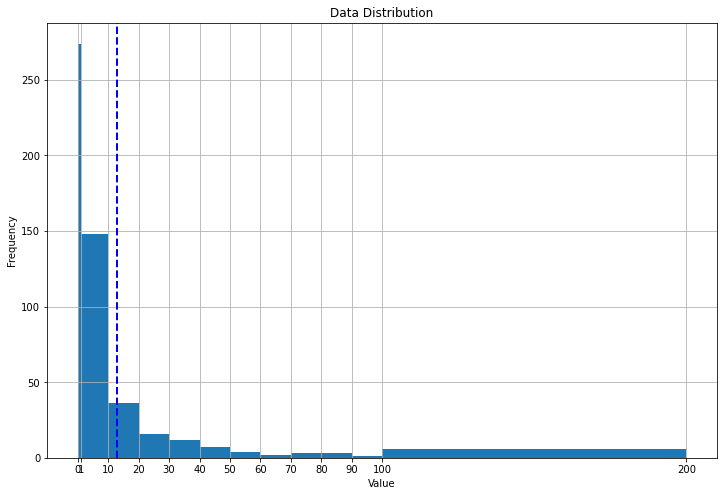

In [21]:
# Get the variable to examine
histData = dataFrame['area']

meanVal = histData.mean()

# Create a Figure
plt.figure(figsize=(12,8))

# Plot a histogram
plt.hist(histData, bins=limits)

plt.axvline(x=meanVal, color = 'blue', linestyle='dashed', linewidth = 2)

# Add titles and labels
plt.title('Data Distribution')
plt.xlabel('Value')
plt.xticks(ticks=limits)
plt.ylabel('Frequency')
plt.grid(True)

# Show the figure
plt.show()

### Distribution of predictor variables

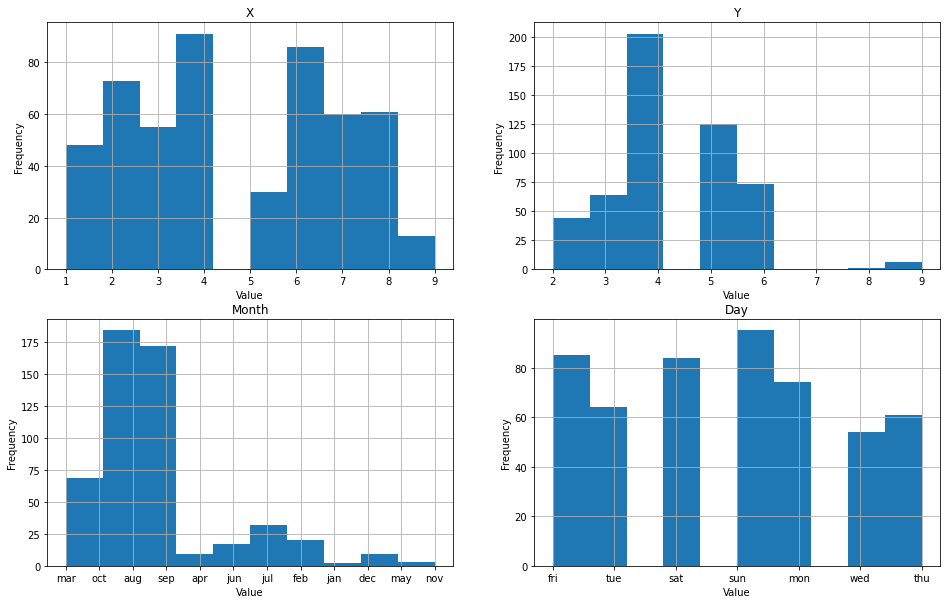

In [22]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(dataFrame['X'])
plt.grid(True)
plt.title('X')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(dataFrame['Y'])
plt.grid(True)
plt.title('Y')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(dataFrame['month'])
plt.grid(True)
plt.title('Month')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(dataFrame['day'])
plt.grid(True)
plt.title('Day')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.show()

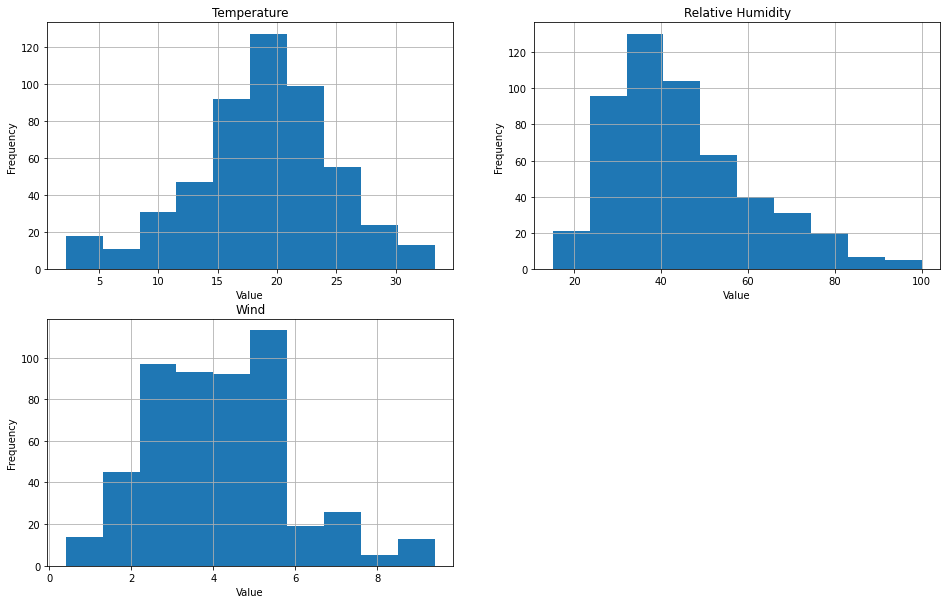

In [23]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(dataFrame['temp'])
plt.grid(True)
plt.title('Temperature')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(dataFrame['RH'])
plt.grid(True)
plt.title('Relative Humidity')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(dataFrame['wind'])
plt.grid(True)
plt.title('Wind')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

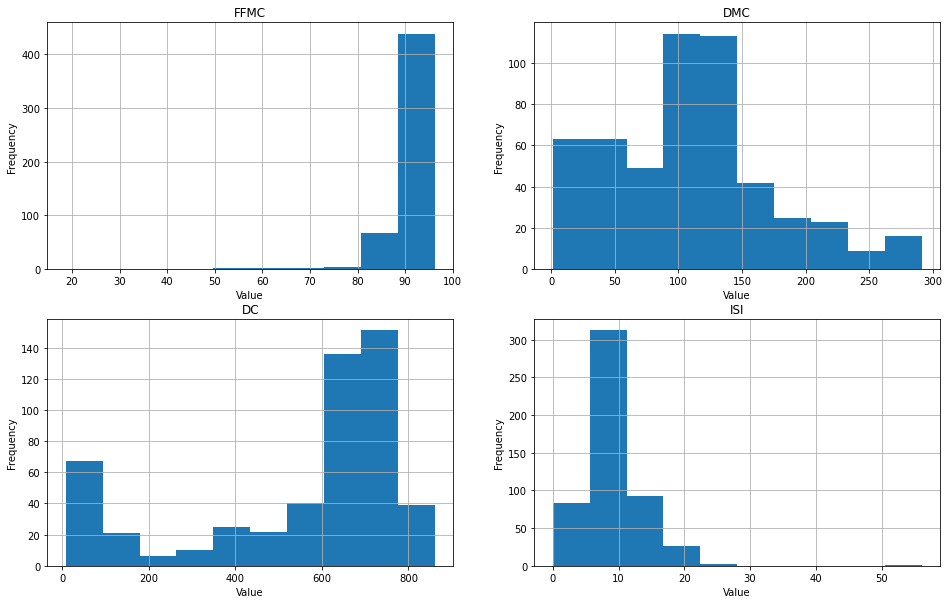

In [24]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(dataFrame['FFMC'])
plt.grid(True)
plt.title('FFMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(dataFrame['DMC'])
plt.grid(True)
plt.title('DMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(dataFrame['DC'])
plt.grid(True)
plt.title('DC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(dataFrame['ISI'])
plt.grid(True)
plt.title('ISI')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

### Correlation between the properties

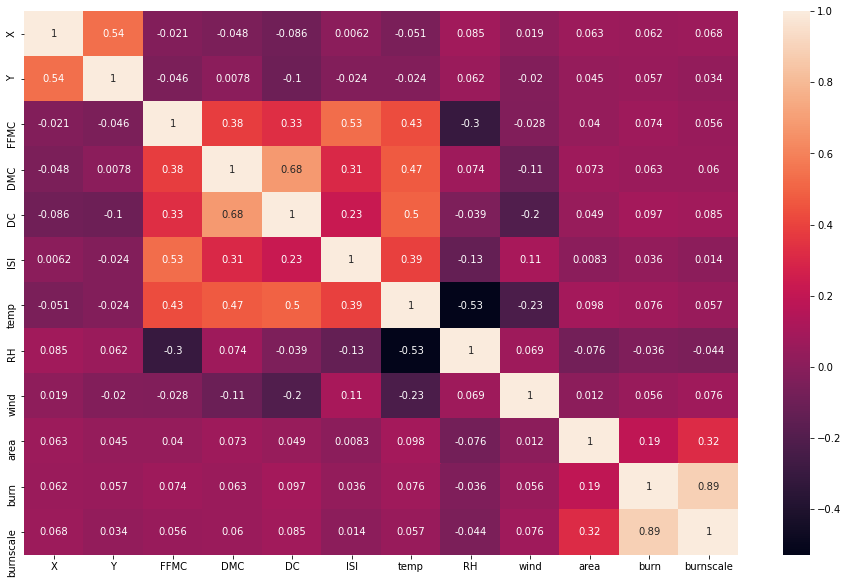

In [25]:
plt.figure(figsize=(16, 10))
corrMatrix = dataFrame.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

### Distribution of burnt area values

In [26]:
dataFrame[['area']].describe()

,area
count,517.000000
mean,12.847292
std,63.655818
min,0.000000
25%,0.000000
50%,0.520000
75%,6.570000
max,1090.840000


#### The mean value of burnt area is more than the 3rd quartile. Thats weird!!

### Let's look at the outliers

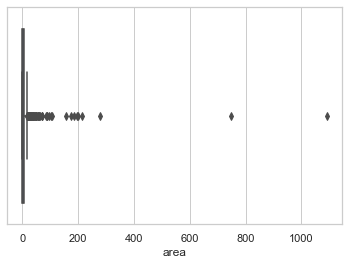

In [27]:
sb.set_theme(style="whitegrid")

ax = sb.boxplot(x=dataFrame["area"])

#### USELESS!!!


#### Calculate the outlier limit

In [28]:
thirdQuartile = dataFrame[['area']].describe().at['75%', 'area']

In [29]:
firstQuartile = dataFrame[['area']].describe().at['25%', 'area']

In [30]:
IQR = thirdQuartile - firstQuartile

In [31]:
outlierLimit = 1.5 * IQR

In [32]:
outlierLimit

9.855

#### Number of outliers

In [33]:
print(len(dataFrame[dataFrame['area'] > outlierLimit]))

97


### Make a dataset without outliers

In [34]:
cleanDF = dataFrame[dataFrame['area'] <= outlierLimit]

In [35]:
cleanDF.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area,burn,burnscale
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,4.611905,4.302381,90.620714,109.586190,543.507857,9.078333,18.884762,44.509524,3.948095,1.515357,0.411905,0.411905
std,2.312021,1.253727,5.767668,62.958875,249.958323,4.634413,5.638184,16.240655,1.763383,2.486176,0.492765,0.492765
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,69.425000,436.600000,6.500000,15.575000,33.000000,2.700000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.650000,106.900000,658.200000,8.400000,19.200000,42.000000,4.000000,0.000000,0.000000,0.000000
75%,6.250000,5.000000,92.800000,142.400000,713.900000,10.700000,22.800000,53.000000,4.900000,2.140000,1.000000,1.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,32.600000,100.000000,9.400000,9.770000,1.000000,1.000000


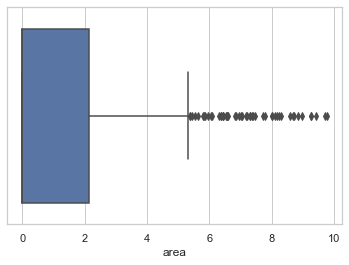

In [36]:
sb.set_theme(style="whitegrid")

ax = sb.boxplot(x=cleanDF["area"])

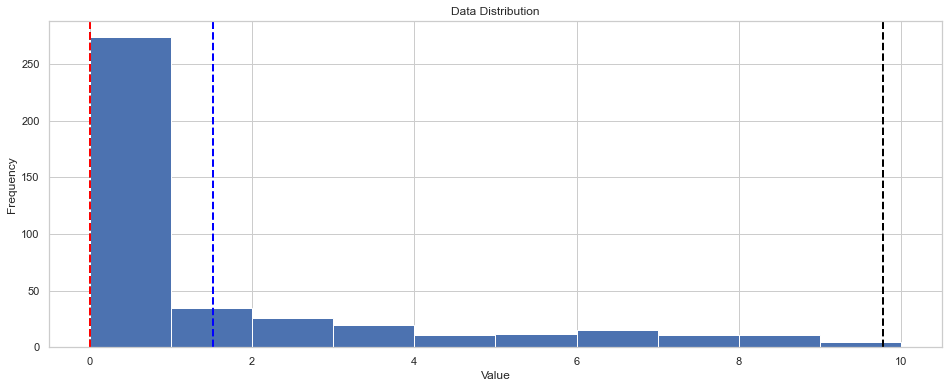

In [37]:
histData = cleanDF['area']


plt.figure(figsize=(16, 6))

minVal = histData.min()
meanVal = histData.mean()
medVal = histData.median()
maxVal = histData.max()


plt.hist(histData, bins=[0,1,2,3,4,5,6,7,8,9,10])

plt.axvline(x=meanVal, color = 'blue', linestyle='dashed', linewidth = 2)
plt.axvline(x=maxVal, color = 'black', linestyle='dashed', linewidth = 2)
plt.axvline(x=minVal, color = 'black', linestyle='dashed', linewidth = 2)
plt.axvline(x=medVal, color = 'red', linestyle='dashed', linewidth = 2)

plt.grid(True)
plt.title('Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

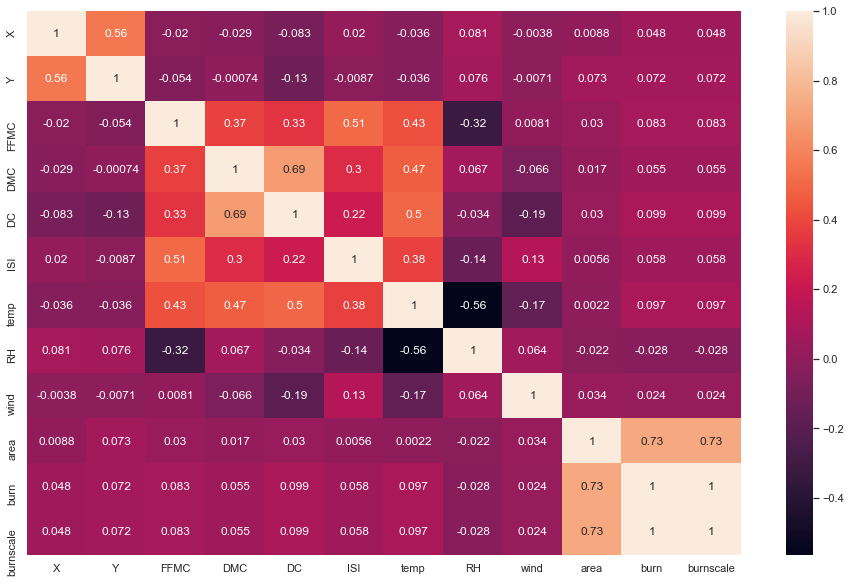

In [38]:
plt.figure(figsize=(16, 10))
corrMatrix = cleanDF.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

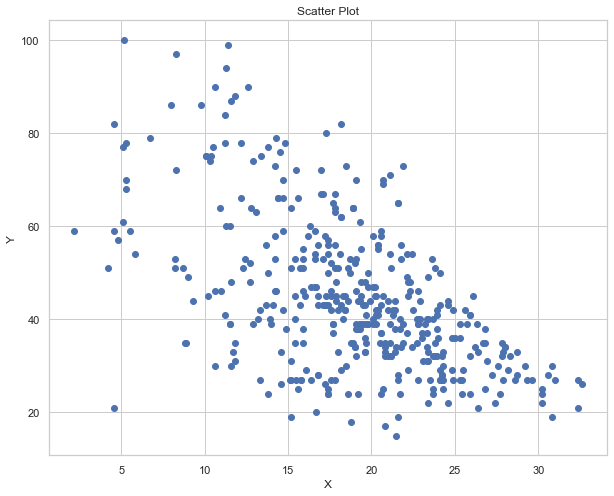

In [39]:
plt.figure(figsize=(10,8))
plt.scatter(x=cleanDF['temp'] , y=cleanDF['RH'])
plt.title('Scatter Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [40]:
list(dataFrame.columns)

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'area',
 'burn',
 'burnscale']

In [41]:
dataFrame.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,area,burn,burnscale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.0,0,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0


In [44]:
X, Y = dataFrame[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']].values, dataFrame['burn'].values

In [48]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.15)

In [49]:
print ('Training Set: {} rows\n\nTest Set: {} rows'.format(XTrain.shape[0], 
                                                           XTest.shape[0]))

Training Set: 439 rows

Test Set: 78 rows


In [48]:
# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver="liblinear").fit(XTrain, YTrain)
print (model)

LogisticRegression(C=100.0, solver='liblinear')


In [49]:
predictions = model.predict(XTest)

In [50]:
predictDF = pd.DataFrame(columns=['Predictions', 'Actual'], 
                         data=zip(predictions, YTest))

In [57]:
print('Accuracy: ', accuracy_score(YTest, predictions))

Accuracy:  0.4807692307692308


In [59]:
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))

Overall Precision: 0.48
Overall Recall: 0.7058823529411765


In [60]:
# Print the confusion matrix
cm = confusion_matrix(YTest, predictions)
print (cm)

[[14 39]
 [15 36]]


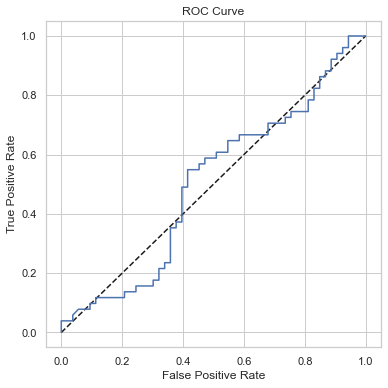

In [61]:
YScores = model.predict_proba(XTest)


%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, YScores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [62]:
auc = roc_auc_score(YTest,YScores[:,1])
print('AUC: ' + str(auc))

AUC: 0.5003699593044766


In [50]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0, 1, 2, 3, 4, 5, 6, 7, 8]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
# categorical_features = [7]
# categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    
    transformers=[
        ('num', numeric_transformer, numeric_features)])



Confusion Matrix:
 [[16 18]
 [21 23]] 

Accuracy: 0.5
Overall Precision: 0.5609756097560976
Overall Recall: 0.5227272727272727
AUC: 0.4759358288770053


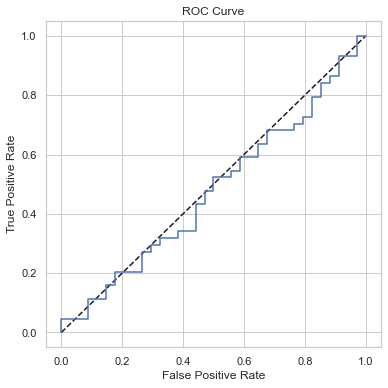

In [62]:
reg = 0.01

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(XTrain, (YTrain))

# Get predictions from test data
predictions = model.predict(XTest)
y_scores = model.predict_proba(XTest)

# Get evaluation metrics
cm = confusion_matrix(YTest, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(YTest, predictions))
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))
auc = roc_auc_score(YTest,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Confusion Matrix:
 [[21 13]
 [16 28]] 

Accuracy: 0.6282051282051282
Overall Precision: 0.6829268292682927
Overall Recall: 0.6363636363636364
AUC: 0.6747994652406417


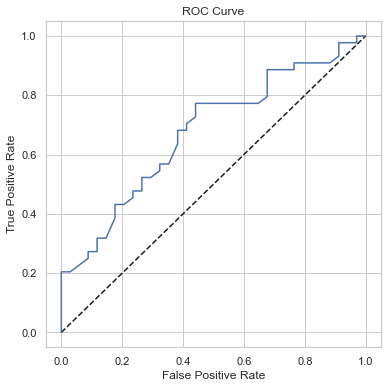

In [65]:
reg = 0.01

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier(n_estimators=100))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(XTrain, (YTrain))

# Get predictions from test data
predictions = model.predict(XTest)
y_scores = model.predict_proba(XTest)

# Get evaluation metrics
cm = confusion_matrix(YTest, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(YTest, predictions))
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))
auc = roc_auc_score(YTest,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Confusion Matrix:
 [[20 14]
 [27 17]] 

Accuracy: 0.47435897435897434
Overall Precision: 0.5483870967741935
Overall Recall: 0.38636363636363635
AUC: 0.5394385026737968


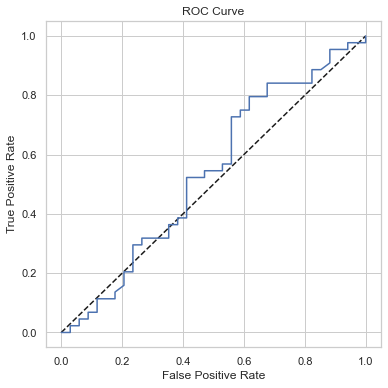

In [66]:
reg = 0.01

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', AdaBoostClassifier())])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(XTrain, (YTrain))

# Get predictions from test data
predictions = model.predict(XTest)
y_scores = model.predict_proba(XTest)

# Get evaluation metrics
cm = confusion_matrix(YTest, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(YTest, predictions))
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))
auc = roc_auc_score(YTest,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Confusion Matrix:
 [[23 11]
 [23 21]] 

Accuracy: 0.5641025641025641
Overall Precision: 0.65625
Overall Recall: 0.4772727272727273
AUC: 0.5905748663101604


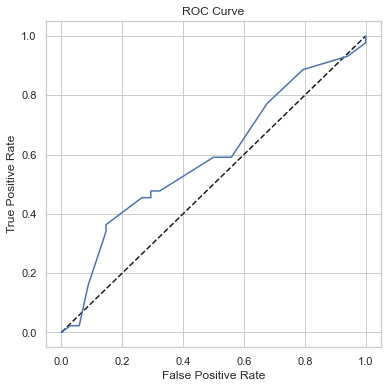

In [67]:
reg = 0.01

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', BaggingClassifier())])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(XTrain, (YTrain))

# Get predictions from test data
predictions = model.predict(XTest)
y_scores = model.predict_proba(XTest)

# Get evaluation metrics
cm = confusion_matrix(YTest, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(YTest, predictions))
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))
auc = roc_auc_score(YTest,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Confusion Matrix:
 [[18 16]
 [19 25]] 

Accuracy: 0.5512820512820513
Overall Precision: 0.6097560975609756
Overall Recall: 0.5681818181818182
AUC: 0.5548128342245989


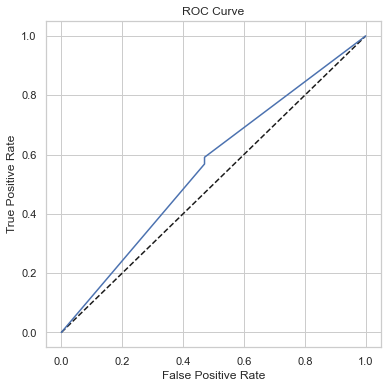

In [72]:
reg = 0.01

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', tree.DecisionTreeClassifier())])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(XTrain, (YTrain))

# Get predictions from test data
predictions = model.predict(XTest)
y_scores = model.predict_proba(XTest)

# Get evaluation metrics
cm = confusion_matrix(YTest, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(YTest, predictions))
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))
auc = roc_auc_score(YTest,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Confusion Matrix:
 [[19 15]
 [20 24]] 

Accuracy: 0.5512820512820513
Overall Precision: 0.6153846153846154
Overall Recall: 0.5454545454545454
AUC: 0.6102941176470589


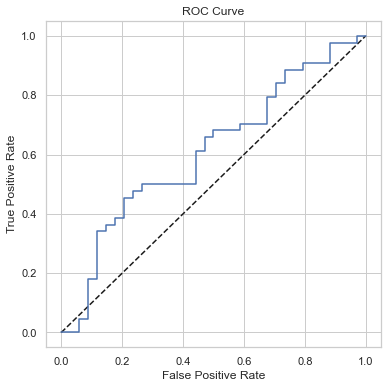

In [74]:
reg = 0.01

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', GradientBoostingClassifier())])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(XTrain, (YTrain))

# Get predictions from test data
predictions = model.predict(XTest)
y_scores = model.predict_proba(XTest)

# Get evaluation metrics
cm = confusion_matrix(YTest, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(YTest, predictions))
print("Overall Precision:",precision_score(YTest, predictions))
print("Overall Recall:",recall_score(YTest, predictions))
auc = roc_auc_score(YTest,y_scores[:,1])
print('AUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTest, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()